In [27]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [28]:
import numpy as np
import pandas as pd

In [29]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [30]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, MetaData, Table
Base = automap_base()

In [31]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base.prepare(engine, reflect=True)
conn = engine.connect()

In [32]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [33]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [34]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#for row in session.query(measurement.prcp).limit(10).all():
 #   print(row)
   
# Calculate the date 1 year ago from the last data point in the database
session.query(measurement.date).order_by(measurement.date.desc()).first()
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(query_date)
# Perform a query to retrieve the data and precipitation scores
df = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date > query_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
data = pd.DataFrame(df)
data = data.set_index('date')
#data.set_index(measurement.date)
data

2016-08-23


,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


Text(0, 0.5, 'Inches')

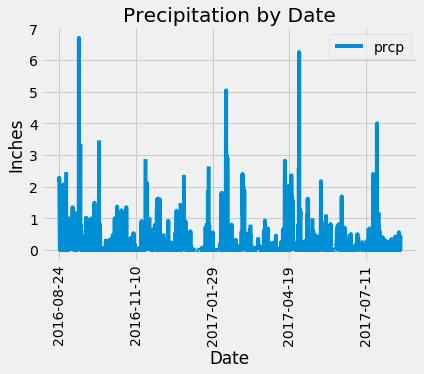

In [10]:

#data['date'] = pd.to_datetime(data.date)
data = data.sort_values(by = 'date', ascending=True)
# Use Pandas Plotting with Matplotlib to plot the data
#data.plot(kind='bar')
data.plot(x_compat=True)
plt.title('Precipitation by Date')
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("Inches")
#plt.tight_layout()
#plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
countsdf = session.query(station.id,station.station,station.name)
stations_df = pd.DataFrame(countsdf)
stations_df.nunique()['station']

query = '''
SELECT DISTINCT station
FROM
station'''

stationdf = pd.read_sql(query, conn)
stationdf

,station
0,USC00519397
1,USC00513117
2,USC00514830
3,USC00517948
4,USC00518838
5,USC00519523
6,USC00519281
7,USC00511918
8,USC00516128


In [13]:
#SQL version
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
query = '''
SELECT
    id, station, count(*)
FROM
    measurement
GROUP BY
    station
    ORDER BY count(*) DESC
    '''

total_df = pd.read_sql(query, conn)
total_df

,id,station,count(*)
0,12188,USC00519281,2772
1,1,USC00519397,2724
2,2725,USC00513117,2709
3,9519,USC00519523,2669
4,16939,USC00516128,2612
5,5434,USC00514830,2202
6,14960,USC00511918,1979
7,7636,USC00517948,1372
8,9008,USC00518838,511


In [14]:
#python version
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

altdf = session.query(measurement.id,measurement.station)
alt1_df = pd.DataFrame(altdf)
alt1_df
alt1_df['station'].value_counts()


USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: station, dtype: int64

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

query = '''
Select max(tobs), min(tobs), avg(tobs) from measurement where station = 'USC00519281'
    '''
maxminavg_df = pd.read_sql(query, conn)
maxminavg_df

,max(tobs),min(tobs),avg(tobs)
0,85.0,54.0,71.663781


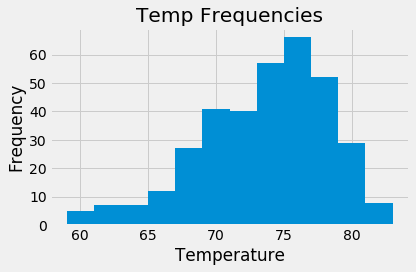

In [16]:
yearyear = pd.read_sql("Select * from measurement where station = 'USC00519281' and date > '2016-08-23'",conn)


#yearyear['tobs'].hist()
plt.title('Temp Frequencies')
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.hist(yearyear['tobs'],bins=12)
plt.tight_layout()

In [17]:
yearstation = pd.read_sql("Select tobs,count(*) from measurement where station = 'USC00519281' and date > '2016-08-23' group by tobs",conn)


In [24]:
#Flask tasks

from flask import Flask, jsonify
app = Flask(__name__)



In [25]:
@app.route("/")
def home():
    """List all available api routes."""
    return (
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/<Start><br/>"
        f"/api/v1.0/<start>/<end>"
    )


In [26]:
#%%
@app.route("/api/v1.0/precipitation")
def precipitation():
    
    results = pd.read_sql('SELECT * FROM measurement', engine)

    results_json = results[['date','prcp']].to_json(orient='records') 

    return results_json

In [21]:
#%%
@app.route('/api/v1.0/stations')
def stations():

    results1 = pd.read_sql("Select distinct station from measurement", engine)

    results1_json = results1.to_json(orient='records') 

    return results1_json

In [22]:
#%%
@app.route('/api/v1.0/tobs')
def tobs_sql():

    results2 = pd.read_sql("Select tobs,count(*) from measurement where station = 'USC00519281' and date > '2016-08-23' group by tobs", engine)

    results2_json = results2.to_json(orient='records') 

    return results2_json

In [23]:

#%%
if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Restarting with fsevents reloader


SystemExit: 1

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
